In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
data_processed = pd.read_csv('processed_films_data.csv', index_col='id')
import warnings

warnings.filterwarnings("ignore")

In [3]:
from sklearn.preprocessing import StandardScaler

numerical_features = ['RatingCount', 'Len_review', 'RatingValue', 
                       'Actors_sum_freq', 'Keywords_sum_freq', 'Date_published_num', 'Count_films']

scaler = StandardScaler()
data_processed[numerical_features] = scaler.fit_transform(data_processed[numerical_features])


In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

X = data_processed[numerical_features]
all_y = data_processed.drop(numerical_features, axis=1)

X_train, X_test, all_y_train, all_y_test = train_test_split(X, all_y, test_size=0.2, random_state=42)

## We select genres with a class balance of at least 0.05, because otherwise classification will be very difficult or impossible

In [6]:
Genres = pd.DataFrame(all_y_train.transpose().mean(axis=1)).reset_index(names='Genre')
Genres = Genres.rename(columns={0: 'balance'})
Genres = Genres[Genres['balance'] >= 0.05]
Genres.head()

,Genre,balance
0,Action,0.149314
2,Adventure,0.105113
3,Animation,0.051051
4,Biography,0.051714
5,Comedy,0.329622


## Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve

def find_threshold(y_test, rfr_prob, beta=1): #Finds the optimal threshold for F1 with weights
    precision, recall, thresholds = precision_recall_curve(y_test, rfr_prob)
    f1_beta_scores = np.zeros_like(precision)

    for i in range(len(precision)):
        if precision[i] + recall[i] > 0:
            f1_beta_scores[i] = (1 + beta**2) * (precision[i] * recall[i]) / (beta**2 * precision[i] + recall[i])
        else:
            f1_beta_scores[i] = 0

    optimal_idx = np.argmax(f1_beta_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_f1_beta_score = f1_beta_scores[optimal_idx]

    return (optimal_threshold, optimal_f1_beta_score, optimal_idx)


def create_plot(recall_values, precision_values, optimal_idx, optimal_f1_beta_score):
    # Building a Precision-Recall curve
    plt.figure(figsize=(4, 3))
    plt.plot(recall_values, precision_values, color='b', lw=2, label='Precision-Recall curve')
    plt.scatter(recall_values[optimal_idx], precision_values[optimal_idx], color='r', label=f'Optimal threshold (F1={optimal_f1_beta_score:0.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()


models_metrics = pd.DataFrame(columns=['Genre', 'Model', 'ROC_AUC', 'Precision', 'Recall', 'Pr_Rec_AUC', 'F1beta_score'])

for i in range(len(Genres)):
    y_train = all_y_train[Genres.iloc[i][0]] 
    y_test = all_y_test[Genres.iloc[i][0]] 
    log_reg = LogisticRegression(class_weight='balanced', random_state=42).fit(X_train, y_train)

    lg_prob = log_reg.predict_proba(X_test)[:,1]

    optimal_threshold, f1_beta_score, optimal_idx = find_threshold(y_test, lg_prob, beta=1.7)
    
    lr_pred = (lg_prob >= optimal_threshold).astype(int)
    
    precision, recall, thresholds = precision_recall_curve(y_test, lg_prob)

    new_row = {'Genre': Genres.iloc[i][0], 'Model': 'LogReg', 'ROC_AUC': roc_auc_score(y_test, lg_prob), 
               'Precision': precision_score(y_test, lr_pred), 
               'Recall': recall_score(y_test, lr_pred), 'Pr_Rec_AUC': auc(recall, precision), 'F1beta_score': f1_beta_score}
    
    models_metrics.loc[len(models_metrics)] = new_row

## SVM

In [10]:
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

for i in range(len(Genres)):
    y_train = all_y_train[Genres.iloc[i][0]] 
    y_test = all_y_test[Genres.iloc[i][0]]

    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    svc = SVC(kernel='linear', probability=True, max_iter=1000, C=0.1, class_weight='balanced', random_state=42).fit(X_train_res, y_train_res)
    svc_prob = svc.predict_proba(X_test)[:,1]

    optimal_threshold, f1_beta_score, optimal_idx = find_threshold(y_test, svc_prob, beta=1.7)

    svc_pred = (svc_prob >= optimal_threshold).astype(int)
    
    precision, recall, thresholds = precision_recall_curve(y_test, svc_prob)

    new_row = {'Genre': Genres.iloc[i][0], 'Model': 'SVM', 'ROC_AUC': roc_auc_score(y_test, svc_prob), 
               'Precision': precision_score(y_test, svc_pred), 
               'Recall': recall_score(y_test, svc_pred), 'Pr_Rec_AUC': auc(recall, precision), 'F1beta_score': f1_beta_score}
    
    models_metrics.loc[len(models_metrics)] = new_row


# Decision Tree

### Previously, the best parameters for each tree were selected using Grid Search

In [13]:
# Previously, the best parameters for each tree were selected using Grid Search
data = {
    'Genre': [
        'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 
        'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 
        'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller'
    ],
    'criterion': [
        'gini', 'gini', 'entropy', 'gini', 'entropy', 
        'entropy', 'gini', 'gini', 'entropy', 'entropy', 
        'gini', 'entropy', 'gini', 'gini', 'entropy'
    ],
    'max_depth': [
        9, 3, 3, 9, 4, 
        4, 9, 9, 9, 6, 
        6, 7, 7, 9, 4
    ],
    'min_samples_leaf': [
        3, 3, 3, 3, 3, 
        9, 3, 9, 3, 7, 
        3, 3, 9, 3, 3
    ]
}

params_df = pd.DataFrame(data)

In [14]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, all_y_train, all_y_test = train_test_split(X, all_y, test_size=0.2, random_state=42)
np.random.seed(42)

for i in params_df.index:
    cur_row = params_df.iloc[i]
    y_train = all_y_train[cur_row['Genre']]
    y_test = all_y_test[cur_row['Genre']] 
    dst = DecisionTreeClassifier(class_weight='balanced', criterion=cur_row['criterion'],
                                 max_depth=cur_row['max_depth'], min_samples_leaf=cur_row['min_samples_leaf'])
    dst.fit(X_train, y_train)

    dst_prob = dst.predict_proba(X_test)[:,1]

    optimal_threshold, f1_beta_score, optimal_idx = find_threshold(y_test, dst_prob, beta=1.7)

    dst_pred = (dst_prob >= optimal_threshold).astype(int)
    precision, recall, thresholds = precision_recall_curve(y_test, dst_prob)
    
    metrics_row = {'Genre': Genres.iloc[i][0], 'Model': 'Decision_Tree', 'ROC_AUC': roc_auc_score(y_test, dst_prob), 
               'Precision': precision_score(y_test, dst_pred), 
               'Recall': recall_score(y_test, dst_pred), 'Pr_Rec_AUC': auc(recall, precision), 'F1beta_score': f1_beta_score}
    
    models_metrics.loc[len(models_metrics)] = metrics_row

# Random Forest 

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score    

for i in range(len(Genres)):
    y_train = all_y_train[Genres.iloc[i][0]] 
    y_test = all_y_test[Genres.iloc[i][0]]
    
    rfr = RandomForestClassifier(class_weight='balanced', random_state = 42, min_samples_leaf=3)
    rfr.fit(X_train, y_train)
    rfr_prob = rfr.predict_proba(X_test)[:, 1]
    optimal_threshold, f1_beta_score, optimal_idx = find_threshold(y_test, rfr_prob, beta=1.7)

    precision, recall, thresholds = precision_recall_curve(y_test, rfr_prob)
        
    rfr_pred = (rfr_prob >= optimal_threshold).astype(int)
    
    metrics_row = {'Genre': Genres.iloc[i][0], 'Model': 'Random_Forest', 'ROC_AUC': roc_auc_score(y_test, rfr_prob), 
               'Precision': precision_score(y_test, rfr_pred), 
               'Recall': recall_score(y_test, rfr_pred), 'Pr_Rec_AUC': auc(recall, precision), 'F1beta_score': f1_beta_score}
    models_metrics.loc[len(models_metrics)] = metrics_row


## An example of one of the Pr-Rec AUC with an optimal threshold

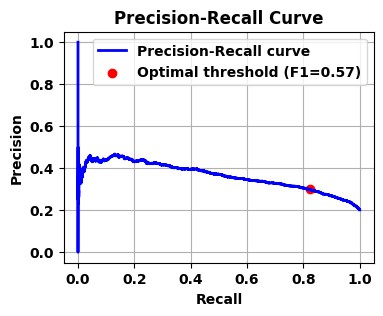

In [18]:
create_plot(recall, precision, optimal_idx, f1_beta_score)

# XGBoost

In [20]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, fbeta_score

def fbeta_scorer(beta=1):
    return make_scorer(fbeta_score, beta=beta)

for i in range(len(Genres)):
    y_train = all_y_train[Genres.iloc[0][0]] 
    y_test = all_y_test[Genres.iloc[0][0]]
    
    model = XGBClassifier()
    params = {'n_estimators': range(100,1000,100), 'max_depth': range(2,5), 'learning_rate': list(np.arange(0.01, 0.3, 0.05))}
    random_search = RandomizedSearchCV(model, params, scoring=fbeta_scorer(beta=1.7), cv=5, verbose=1)
    random_search.fit(X_train, y_train)
    
    best_xgb = random_search.best_estimator_
    xgb_prob = best_xgb.predict_proba(X_test)[:, 1]
    optimal_threshold, f1_beta_score, optimal_idx = find_threshold(y_test, xgb_prob, beta=1.7)
    xgb_pred = (xgb_prob >= optimal_threshold).astype(int)
    precision, recall, thresholds = precision_recall_curve(y_test, xgb_prob)
    
    metrics_row = {'Genre': Genres.iloc[i][0], 'Model': 'XGBoost', 'ROC_AUC': roc_auc_score(y_test, xgb_prob), 
               'Precision': precision_score(y_test, xgb_pred), 
               'Recall': recall_score(y_test, xgb_pred), 'Pr_Rec_AUC': auc(recall, precision), 'F1beta_score': f1_beta_score}
    
    models_metrics.loc[len(models_metrics)] = metrics_row

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


# Results

In [22]:
model_order = ['LogReg', 'SVM', 'Decision_Tree', 'Random_Forest', 'XGBoost']
models_metrics['Model_Order'] = models_metrics['Model'].apply(lambda x: model_order.index(x))
models_metrics = models_metrics.sort_values(['Genre', 'Model_Order'])
models_metrics = models_metrics.drop('Model_Order', axis=1)

In [23]:
models_metrics

,Genre,Model,ROC_AUC,Precision,Recall,Pr_Rec_AUC,F1beta_score
0,Action,LogReg,0.672098,0.196984,0.785191,0.289380,0.444206
15,Action,SVM,0.558043,0.158494,0.928886,0.190070,0.412923
30,Action,Decision_Tree,0.688331,0.207551,0.810117,0.294179,0.463897
45,Action,Random_Forest,0.720644,0.222400,0.815249,0.334503,0.483751
60,Action,XGBoost,0.714126,0.215064,0.810117,0.332905,0.473400
...,...,...,...,...,...,...,...
14,Thriller,LogReg,0.684021,0.257823,0.865900,0.319966,0.539065
29,Thriller,SVM,0.514308,0.204545,0.985222,0.221461,0.497300
44,Thriller,Decision_Tree,0.703114,0.258140,0.906951,0.363525,0.550963
59,Thriller,Random_Forest,0.725948,0.299303,0.823207,0.362728,0.567738


## Visualization of the results for each metric

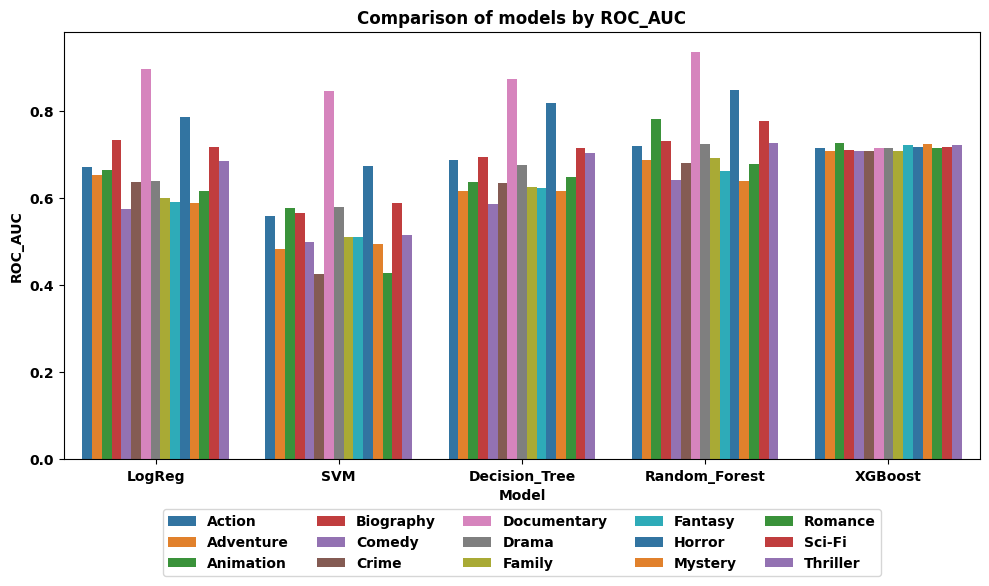

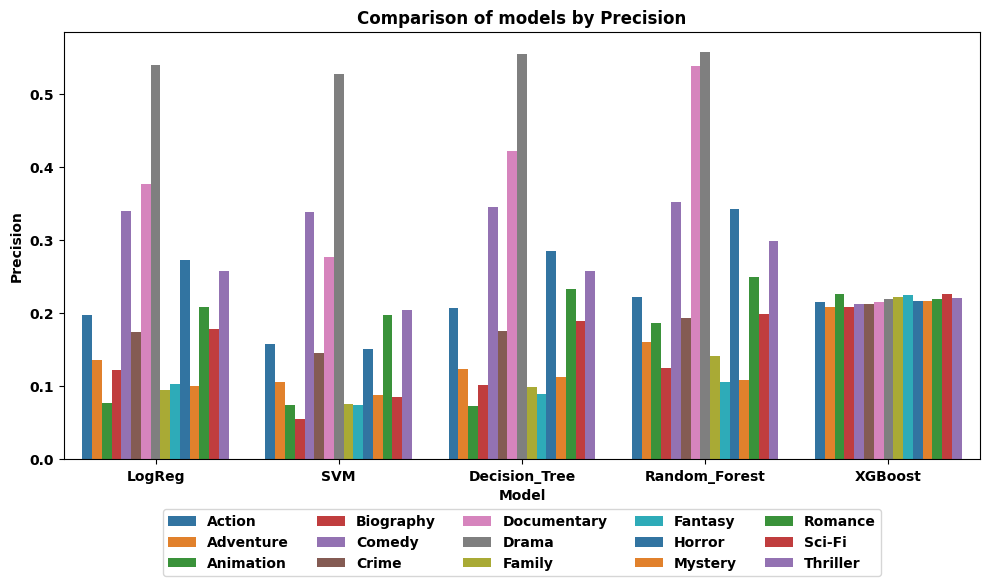

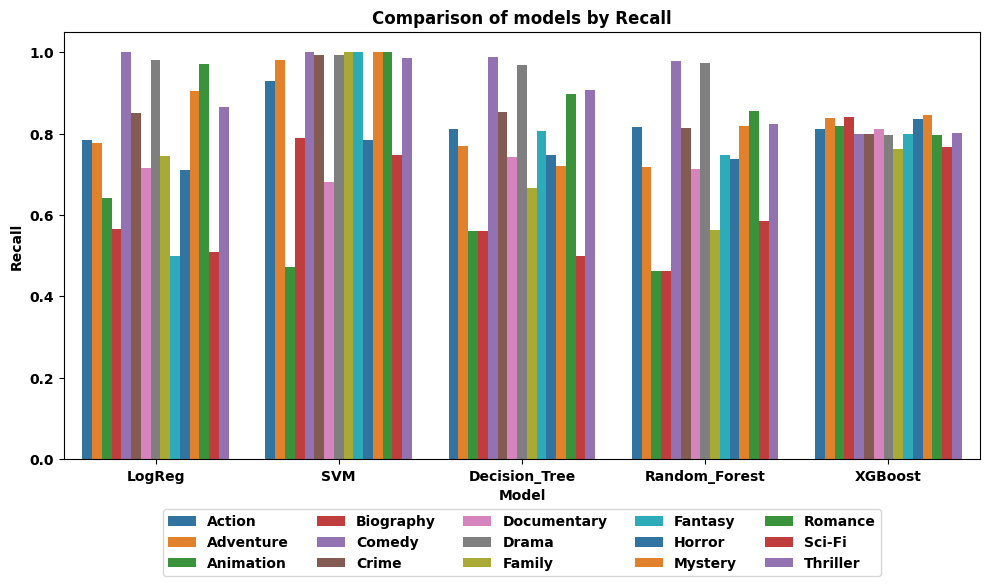

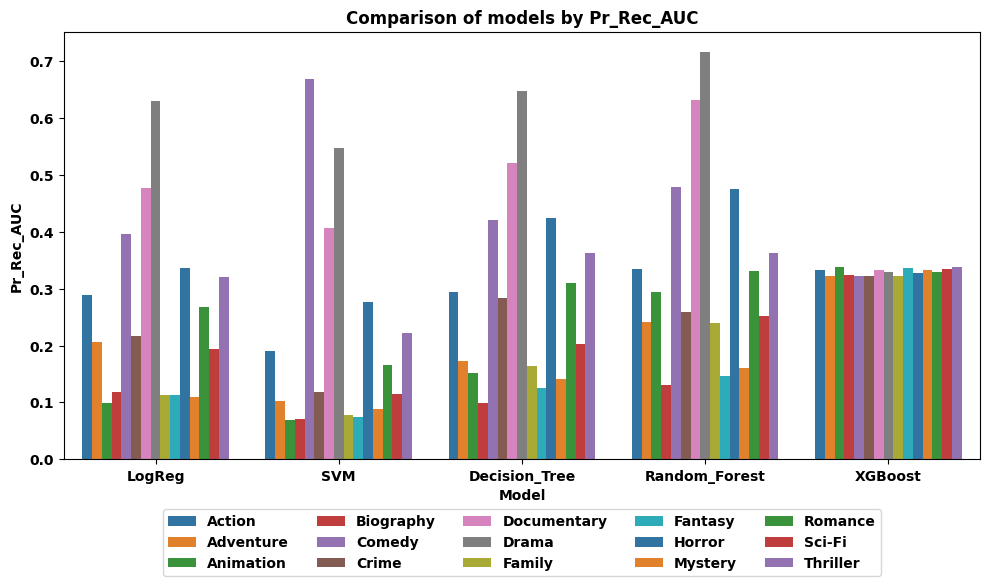

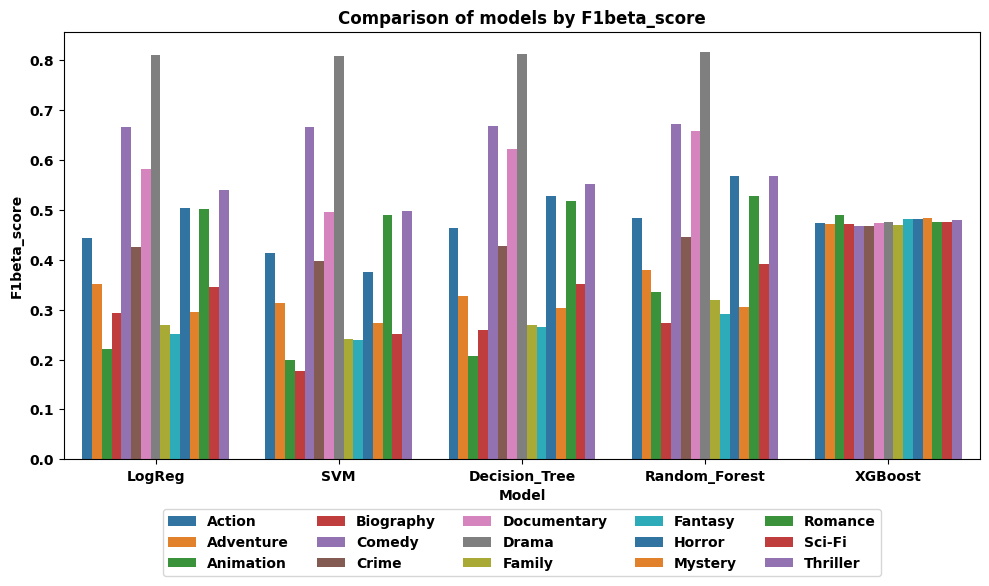

In [25]:
for metric in models_metrics.columns[2:]:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=models_metrics, x='Model', y=metric, hue='Genre', palette='tab10')
    plt.title(f'Comparison of models by {metric}')
    plt.ylabel(metric)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)
    plt.tight_layout()
    plt.show()

## The best models for each genre according to the F1_beta metric

In [27]:
models_metrics.loc[models_metrics.groupby('Genre')['F1beta_score'].idxmax()]

,Genre,Model,ROC_AUC,Precision,Recall,Pr_Rec_AUC,F1beta_score
45,Action,Random_Forest,0.720644,0.222400,0.815249,0.334503,0.483751
61,Adventure,XGBoost,0.707978,0.208379,0.838710,0.322121,0.471817
62,Animation,XGBoost,0.726754,0.226120,0.817449,0.337592,0.488828
63,Biography,XGBoost,0.711265,0.208462,0.841642,0.324232,0.472615
49,Comedy,Random_Forest,0.642492,0.351928,0.978495,0.478872,0.671267
65,Crime,XGBoost,0.707496,0.212754,0.799853,0.322133,0.467917
51,Documentary,Random_Forest,0.935058,0.539315,0.712383,0.630990,0.658094
52,Drama,Random_Forest,0.723701,0.557638,0.972405,0.715922,0.816320
68,Family,XGBoost,0.708195,0.222842,0.760997,0.322905,0.469516
69,Fantasy,XGBoost,0.721411,0.225279,0.798387,0.336224,0.482706
